In [ ]:
!pip install cirq

     |████████████████████████████████| 328 kB 26.4 MB/s 
     |████████████████████████████████| 1.6 MB 43.8 MB/s 
     |████████████████████████████████| 47 kB 4.6 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 437 kB 46.2 MB/s 
     |████████████████████████████████| 145 kB 46.1 MB/s 
     |████████████████████████████████| 53 kB 1.0 MB/s 
     |████████████████████████████████| 49 kB 3.3 MB/s 
     |████████████████████████████████| 220 kB 49.8 MB/s 
     |████████████████████████████████| 10.1 MB 46.4 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 229 kB 69.2 MB/s 
     |████████████████████████████████| 243 kB 67.5 MB/s 
     |███████████████████████

In [1]:
import numpy as np
import random
import time
import itertools as itert
import cirq
import matplotlib.pyplot as plt
import math


Deutsche Jozsa

In [2]:
def createUfDJ(n, fntype, verbose = True):
    ufMatrix = np.zeros((2**n,2**n))

    # Constant Function
    if fntype == 0:
        typeOfFn = np.random.randint(low = 0, high = 2)
        if verbose:
            print('Function is constant ', typeOfFn)

        # Constant 0 means f(x) = 0 always and hence the qubits remain as such. Identity Matrix
        if typeOfFn == 0:
            return np.eye(2**n)

        # Constant 1. Here we change the last qubit alone as (b xor 1). Which means we change the last bit alone.
        for i in range(2**n):
            if i % 2 == 0:
                ufMatrix[i+1][i] = 1
            else:
                ufMatrix[i-1][i] = 1
    else:
        ufMatrix = np.eye(2**n)

        # For half the inputs f(x) = 0, so they have x,x value of matrix as 1. For the rest, we need to swap the last bit. We need to take half of possible x values, without helper qubit.
        randList = random.sample(range(0, 2**(n-1)), 2**(n-2))
        for val in randList:
            # For each of the x, helper qubit can be 0 or 1. Handle both cases. Added last bit 0, is same as (*2) and last 1 is (*2 + 1)

            ufMatrix[val*2][val*2] = 0
            ufMatrix[val*2 + 1][val*2 + 1] = 0
            ufMatrix[val*2 + 1][val*2] = 1
            ufMatrix[val*2][val*2 + 1] = 1

    if verbose:
        print("Matrix Uf:")
        print(ufMatrix)

    return ufMatrix
        
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def runAndPrint(n, qubits, ufMatrix, verbose):
    # Time taken by program needs to be checked.
    start = time.time()
    # Defining start of Cirq program
    c = cirq.Circuit()

    # setting last qubit to 1
    c.append(cirq.X(qubits[n-1]))
    
    # adding Hadamard gates to all qubits
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])
    
    # creating Uf gate
    uf_bv = Oracle(n, ufMatrix, "UF")
    
    # adding Uf gate
    c.append(uf_bv(*qubits))
    
    # helper bit does not require H gate. Result is treated as trash/ garbage    
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])        
    
    # measurements
    c.append(cirq.measure(*qubits[:-1], key='result'))
       
    mid = time.time()

    simulator = cirq.Simulator()
    
    result = simulator.run(c, repetitions = 30)
    end = time.time()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
    
        print("Results: ")
        print(result)

        frequencies = result.histogram(key="result", fold_func = bitstring)
        print('Sampled results:\n{}'.format(frequencies))
        _ = cirq.vis.plot_state_histogram(frequencies, plt.subplot())

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for execution: ", end - mid)
        print("Time taken by program: ", end - start)

    return (mid - start, end - mid)

# typeOfFn of 0 implies constant functions. 1 implies uniform.
def runMainCircuitDJ(n = 0, typeOfFn = -1, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)

    n = n + 1
    # Defining n + 1 qubits 
    qubits = cirq.LineQubit.range(n)

    if typeOfFn == -1:
        typeOfFn = np.random.randint(low = 0, high = 2)
    if verbose:
        print('Type: ', typeOfFn)

    ufMatrix = createUfDJ(n, typeOfFn, verbose)

    return runAndPrint(n, qubits, ufMatrix, verbose)

Input Length:  1
Type:  1
Matrix Uf:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=111111111111111111111111111111
Sampled results:
Counter({'1': 30})
Time taken to create circuit:  0.005518436431884766
Time taken for execution:  0.02925395965576172
Time taken by program:  0.034772396087646484
0.005518436431884766 0.02925395965576172


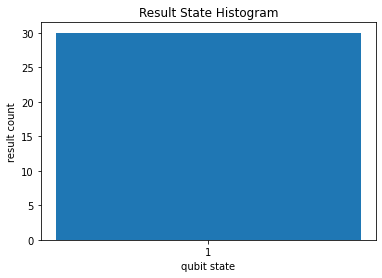

In [3]:
(circuitTime, runTime) = runMainCircuitDJ(1)
print (circuitTime, runTime)

Correctness Tests

Input Length:  1
Type:  0
Function is constant  0
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=000000000000000000000000000000
Sampled results:
Counter({'0': 30})
Time taken to create circuit:  0.0015070438385009766
Time taken for execution:  0.015133380889892578
Time taken by program:  0.016640424728393555


(0.0015070438385009766, 0.015133380889892578)

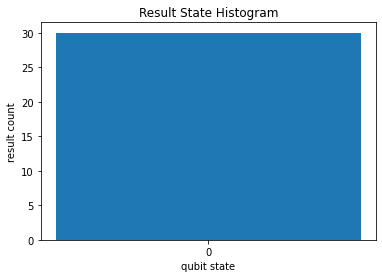

In [4]:
# Constant n = 1
runMainCircuitDJ(1, 0)

Input Length:  1
Type:  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=111111111111111111111111111111
Sampled results:
Counter({'1': 30})
Time taken to create circuit:  0.00078582763671875
Time taken for execution:  0.003964424133300781
Time taken by program:  0.004750251770019531


(0.00078582763671875, 0.003964424133300781)

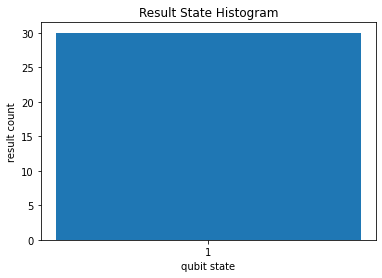

In [5]:
# Uniform n = 1
runMainCircuitDJ(1, 1)

Input Length:  2
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │
2: ───X───H───#3───H─────────────────
Results: 
result=000000000000000000000000000000, 000000000000000000000000000000
Sampled results:
Counter({'00': 30})
Time taken to create circuit:  0.0030670166015625
Time taken for execution:  0.010539770126342773
Time taken by program:  0.013606786727905273


(0.0030670166015625, 0.010539770126342773)

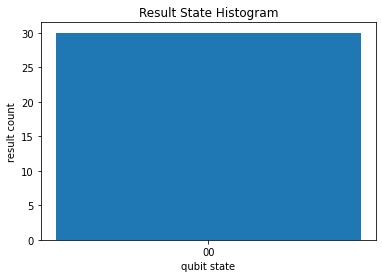

In [6]:
# Constant n = 2
runMainCircuitDJ(2, 0)

Input Length:  2
Type:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │
2: ───X───H───#3───H─────────────────
Results: 
result=000000000000000000000000000000, 111111111111111111111111111111
Sampled results:
Counter({'01': 30})
Time taken to create circuit:  0.003954172134399414
Time taken for execution:  0.0055561065673828125
Time taken by program:  0.009510278701782227


(0.003954172134399414, 0.0055561065673828125)

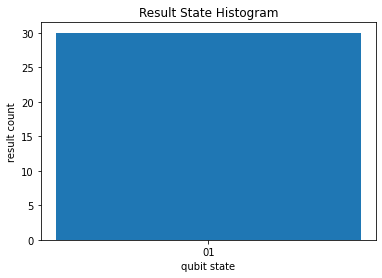

In [7]:
# Uniform n = 2
runMainCircuitDJ(2, 1)

Input Length:  3
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M───

(0.002137899398803711, 0.007184028625488281)

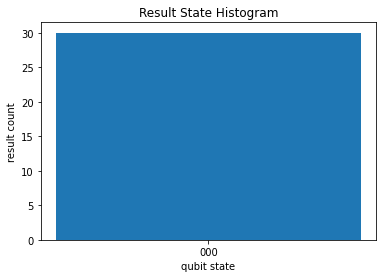

In [13]:
# Constant n = 3
runMainCircuitDJ(3, 0)

Input Length:  3
Type:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
             

(0.0023679733276367188, 0.0078105926513671875)

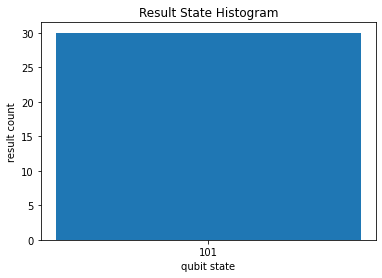

In [14]:
# Uniform n = 3
runMainCircuitDJ(3, 1)

Time for various Uf for n = 5 and Uniform

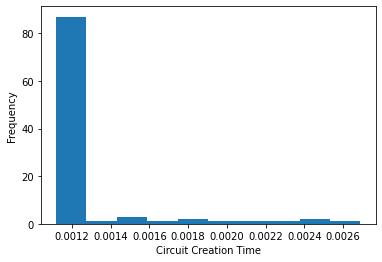

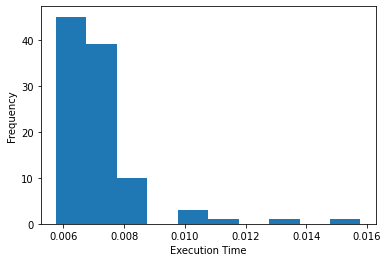

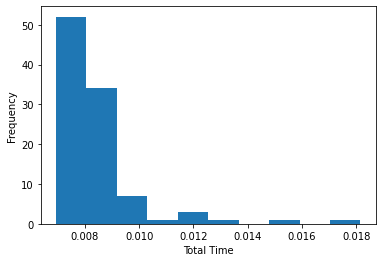

In [15]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(100):
    (circuit, execution) = runMainCircuitDJ(5, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Time difference for Constant functions (Only 2 possible) for n = 5

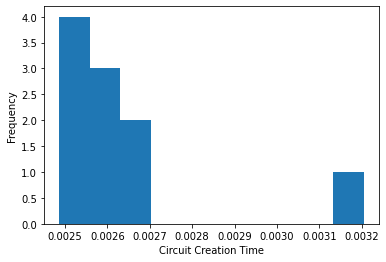

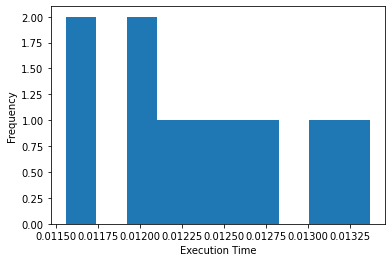

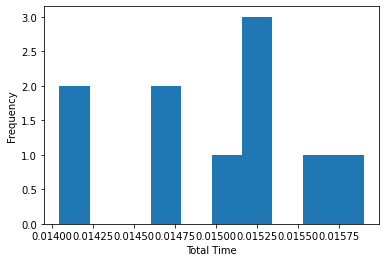

In [20]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(10):
    (circuit, execution) = runMainCircuitDJ(5, 0, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Effect of n on execution time

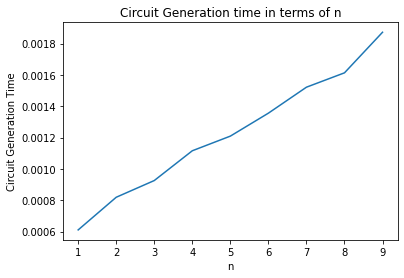

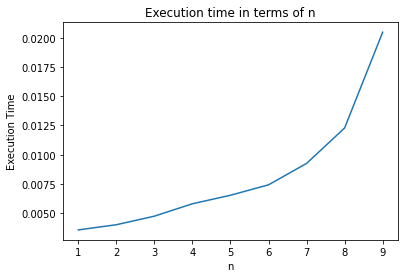

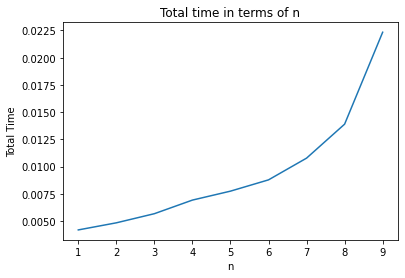

In [37]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 10):
    ct = 0
    et = 0
    tt = 0
    for i in range(100):
        (circuit, execution) = runMainCircuitDJ(n, 1, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 